<a href="https://colab.research.google.com/github/NateshReddy/PCB-Failure-Analyser-playground/blob/main/pcb_start_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Project/failure_analysis/notebooks") #changing the directory

In [ ]:
#import 
import shutil
import cv2
import numpy as np
import json
import glob
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.utils import resample
from fastai.vision import *
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


# Extracting Errors

In [ ]:
# to create directories from storing images
os.mkdir("6_difference_img")  #to store the differenced images
os.mkdir("6_extracted_errors") #to store the extracted errors from differenced images
os.mkdir("6_hold_out") #to store images for testing

In [ ]:
# Load Template and Test images
image_path = 'DeepPCB/PCBData/'
temp_pattern = '/*temp.jpg'
test_pattern = '/*test.jpg'

temps_and_tests = {}

for folder in os.listdir(image_path):
    full_path = image_path + folder + '/' + folder.replace('group', '')
    temps = glob.glob(full_path + '/' + temp_pattern)
    tests = glob.glob(full_path + '/' + test_pattern)
    inner = {}
    inner['temps'] = temps
    inner['tests'] = tests
    temps_and_tests[folder] = inner

In [ ]:
# taking only group00041 for now, can take as many folder as one want(change the numbering of diff images accordingly)
len(temps_and_tests['group00041']['temps'])

221

In [ ]:
# to extract differenced images
def subtract_images(image_path_1, image_path_2, write_path, choice):
    image1 = cv2.imread(image_path_1)
    image2 = cv2.imread(image_path_2)
    difference = cv2.subtract(image1, image2)
    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    difference[mask != 255] = [0, 0, 255]
    image1[mask != 255] = [0, 0, 255]
    image2[mask != 255] = [0, 0, 255]
    if choice == 1: #to extract black over white errors
      cv2.imwrite(write_path, image1)
    elif choice == 2:#to extract white over black errors
      cv2.imwrite(write_path, image2)

In [ ]:
# to remove any left image
#!rm 6_difference_img/*

In [ ]:
split_percentage = round(len(temps_and_tests['group00041']['temps']) * 0.2) # 20% is stored in holdout for inference purposes
last = 177
for index, whatever in enumerate(temps_and_tests['group00041']['temps']):
  #print(index)
  root_img_name = temps_and_tests['group00041']['temps'][index].replace('_temp.jpg', '')
  temp_file_path = root_img_name  + '_temp.jpg'
  test_file_path = root_img_name + '_test.jpg'
  write_path_b = "6_difference_img/diff_image_" + str(index) + ".png"
  write_path_w = "6_difference_img/diff_image_" + str(last + index) + ".png"
  # for keeping hold out set
  if(index < split_percentage):
    print(index)
    for file in [temp_file_path]:
      shutil.copy(file, "6_hold_out/")
    for file in [test_file_path]:
      shutil.copy(file, "6_hold_out/")
  else:
    subtract_images(temp_file_path, test_file_path, write_path_b, 1) #black defects
    subtract_images(test_file_path, temp_file_path, write_path_w, 2) #white defects
  
  '''# without holdout
  subtract_images(temp_file_path, test_file_path, write_path_b, 1) #black defects
  subtract_images(test_file_path, temp_file_path, write_path_w, 2) #white defects'''

In [ ]:
all_differenced_images = os.listdir('6_difference_img')

In [ ]:
len(all_differenced_images)

354

In [ ]:
# to extract errors from each image
def extract_contours_from_image(image_path, write_path, hsv_lower, hsv_upper):
    image = cv2.imread(image_path)
    original = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_lower = np.array(hsv_lower)
    hsv_upper = np.array(hsv_upper)
    mask = cv2.inRange(hsv, hsv_lower, hsv_upper) #if red pixel, then 255 otherwise 0
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
    cnts, _ = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    offset = 20
    ROI_number = 0
    if cnts!=None:
      for c in cnts:
          x, y, w, h = cv2.boundingRect(c)
          cv2.rectangle(image, (x - offset, y - offset), (x + w + offset, y + h + offset), (36, 255, 12), 2)
          ROI = original[y - offset:y + h + offset, x - offset:x + w + offset]
          try:
              cv2.imwrite(write_path + 'contour_{}.png'.format(ROI_number), ROI)
          except:
              print("skipping image " + image_path + "for counter" + str(ROI_number))
          ROI_number += 1
    else:
      print("No counters found at " + image_path)
    

In [ ]:
for index, filename in enumerate(all_differenced_images):
    os.mkdir("6_extracted_errors/extracts_" + str(index))
    image_path = "6_difference_img/" + filename
    this_write_path = "6_extracted_errors/extracts_" + str(index) + "/"
    hsv_lower = [0,150,50], #for red colour
    hsv_upper = [10,255,255]
    extract_contours_from_image(image_path, this_write_path, hsv_lower, hsv_upper)

skipping image 6_difference_img/diff_image_222.pngfor counter9
skipping image 6_difference_img/diff_image_222.pngfor counter10
skipping image 6_difference_img/diff_image_222.pngfor counter11
skipping image 6_difference_img/diff_image_224.pngfor counter4
skipping image 6_difference_img/diff_image_224.pngfor counter5
skipping image 6_difference_img/diff_image_224.pngfor counter6
skipping image 6_difference_img/diff_image_50.pngfor counter0
skipping image 6_difference_img/diff_image_230.pngfor counter3
skipping image 6_difference_img/diff_image_54.pngfor counter4
skipping image 6_difference_img/diff_image_54.pngfor counter7
skipping image 6_difference_img/diff_image_54.pngfor counter17
skipping image 6_difference_img/diff_image_54.pngfor counter18
skipping image 6_difference_img/diff_image_54.pngfor counter19
skipping image 6_difference_img/diff_image_54.pngfor counter20
skipping image 6_difference_img/diff_image_54.pngfor counter21
skipping image 6_difference_img/diff_image_54.pngfor cou

In [ ]:
#!rm -r 6_extracted_defects/*

In [ ]:
check_all_extracted_folder = os.listdir('6_extracted_errors')
len(check_all_extracted_folder)

354

In [ ]:
os.mkdir("6_all_extracts")

In [ ]:
cnt=0
for dirpath, dirs, files in os.walk("6_extracted_errors"):
    for index, filename in enumerate(files):
        if filename.endswith(".png"):
            cnt += 1
            file_paths = [dirpath + "/" + filename]
            target_directory = "6_all_extracts/extract_" + str(cnt) + ".png"
            for file in file_paths:
              shutil.move(file, target_directory)

In [ ]:
check_all_extracted = os.listdir('6_all_extracts')
len(check_all_extracted)

2980

In [ ]:
!zip -r /6_extracted_defects.zip 6_all_extracts/ #zipping the images for labelling

  adding: 6_all_extracts/ (stored 0%)
  adding: 6_all_extracts/extract_1.png (stored 0%)
  adding: 6_all_extracts/extract_2.png (deflated 3%)
  adding: 6_all_extracts/extract_3.png (stored 0%)
  adding: 6_all_extracts/extract_4.png (deflated 5%)
  adding: 6_all_extracts/extract_5.png (deflated 7%)
  adding: 6_all_extracts/extract_6.png (deflated 7%)
  adding: 6_all_extracts/extract_7.png (deflated 6%)
  adding: 6_all_extracts/extract_8.png (deflated 31%)
  adding: 6_all_extracts/extract_9.png (deflated 22%)
  adding: 6_all_extracts/extract_10.png (stored 0%)
  adding: 6_all_extracts/extract_11.png (deflated 4%)
  adding: 6_all_extracts/extract_12.png (deflated 12%)
  adding: 6_all_extracts/extract_13.png (deflated 6%)
  adding: 6_all_extracts/extract_14.png (deflated 19%)
  adding: 6_all_extracts/extract_15.png (deflated 3%)
  adding: 6_all_extracts/extract_16.png (deflated 4%)
  adding: 6_all_extracts/extract_17.png (deflated 14%)
  adding: 6_all_extracts/extract_18.png (deflated 8%)


## Making a json file for labelling, can be skipped if using an online tool for annotations

In [ ]:
file_names_and_sizes = {}
file_names = os.listdir('6_all_extracts/')

for index, file in enumerate(file_names):
  file_names_and_sizes[file_names[index]] = os.path.getsize('6_all_extracts/' + file)

In [ ]:
file_names_and_sizes = {k: v for k, v in file_names_and_sizes.items() if v != 0}

In [ ]:
with open('6_extracted_failures.json', 'w') as outfile:
    json.dump(file_names_and_sizes, outfile)

# Preparing CSV's for training <br>
This has to be done once the labelling is done and load the labelled csv file in the respective folder

In [ ]:
image_labels_frame = pd.read_csv('image_labels_downsampled.csv')  #csv file after downsampling, first the normal one was loaded and then downsampled

Downsampling code has been commented as it was used once

In [ ]:
 image_labels_frame.head(10)

,name,label
0,extract_5.png,NOT
1,extract_6.png,spur
2,extract_7.png,spur
3,extract_8.png,short
4,extract_9.png,spurious_copper
5,extract_11.png,mousebite
6,extract_12.png,open
7,extract_13.png,pin_hole
8,extract_14.png,mousebite
9,extract_18.png,NOT


In [ ]:
len(image_labels_frame)

2137

Splitting the data for train and validation with 90/10 ratio

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(image_labels_frame, test_size=0.1, random_state=42)

In [ ]:
train = train.sort_index()
train = train.reset_index()
train = train.drop(columns='index')
train.tail()

,name,label
1918,extract_2976.png,spur
1919,extract_2977.png,pin_hole
1920,extract_2978.png,mousebite
1921,extract_2979.png,open
1922,extract_2980.png,open


In [ ]:
test = test.sort_index()
test = test.reset_index()
test = test.drop(columns='index')
test.tail()

,name,label
209,extract_2913.png,mousebite
210,extract_2927.png,spurious_copper
211,extract_2957.png,pin_hole
212,extract_2968.png,open
213,extract_2973.png,open


### Count no. of labels in each class in train set

In [ ]:
counts = train['label'].value_counts()
all_features = list(train['label'].value_counts().index.values)
train_labelled_counts = {}
for index, ff in enumerate(all_features):
    train_labelled_counts[ff] = counts[index]
train_labelled_counts

{'NOT': 721,
 'mousebite': 291,
 'open': 213,
 'pin_hole': 176,
 'short': 165,
 'spur': 190,
 'spurious_copper': 167}

### Count no. of labels in each class in val set

In [ ]:
counts = test['label'].value_counts()
all_features = list(test['label'].value_counts().index.values)
test_labelled_counts = {}
for index, ff in enumerate(all_features):
    test_labelled_counts[ff] = counts[index]
test_labelled_counts

{'NOT': 79,
 'mousebite': 25,
 'open': 31,
 'pin_hole': 17,
 'short': 12,
 'spur': 29,
 'spurious_copper': 21}

### Visualizing Train and Val set

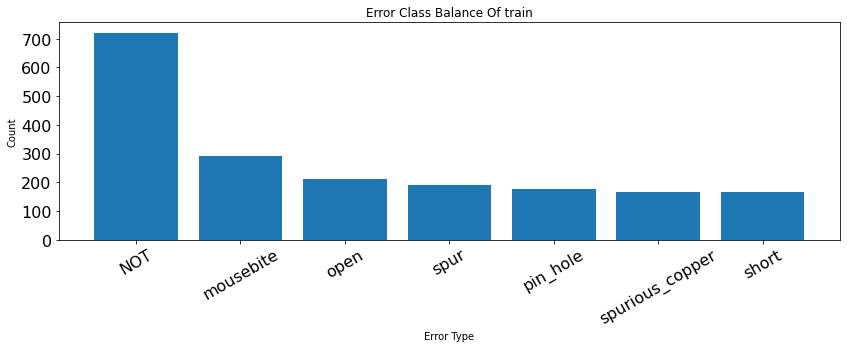

In [ ]:
rcParams['figure.figsize'] = 14, 4
rcParams['text.color'] = "black"
rcParams['axes.labelcolor'] = "black"
rcParams['xtick.color'] = "black"
rcParams['ytick.color'] = "black"

index = np.arange(len(train_labelled_counts.keys()))
plt.bar(index, list(train_labelled_counts.values()))
plt.xlabel('Error Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, train_labelled_counts.keys(), fontsize=5, rotation=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Error Class Balance Of train')
plt.show()

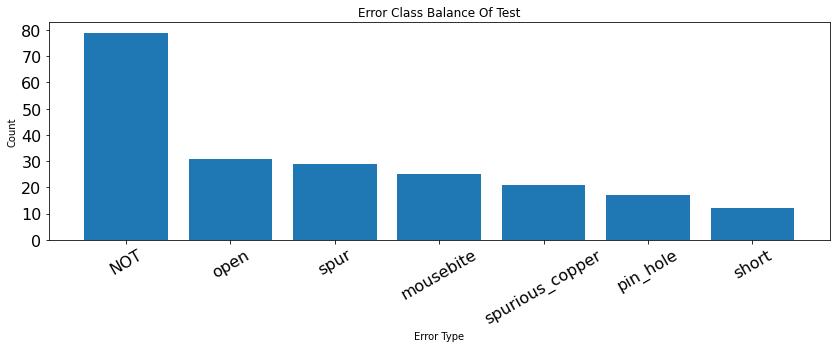

In [ ]:
rcParams['figure.figsize'] = 14, 4
rcParams['text.color'] = "black"
rcParams['axes.labelcolor'] = "black"
rcParams['xtick.color'] = "black"
rcParams['ytick.color'] = "black"

index = np.arange(len(test_labelled_counts.keys()))
plt.bar(index, list(test_labelled_counts.values()))
plt.xlabel('Error Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, test_labelled_counts.keys(), fontsize=5, rotation=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Error Class Balance Of Test')
plt.show()

##### Code for downsampling of 'NOT'. Once the downsampling is done, load the new csv file and run above cells again

In [ ]:
'''df_majority = image_labels_frame[image_labels_frame.label == 'NOT']
df_minority = image_labels_frame[image_labels_frame.label != 'NOT']
df_majority_downsampled = resample(df_majority, replace=False, n_samples=800, random_state=100)
image_labels_frame_d = pd.concat([df_majority_downsampled, df_minority])
image_labels_frame_d.label.value_counts()
image_labels_frame_d = image_labels_frame_d.sort_index()
image_labels_frame_d = image_labels_frame_d.reset_index()
image_labels_frame_d = image_labels_frame_d.drop(columns='index')
image_labels_frame_d.to_csv('image_labels_downsampled.csv', index = False)'''

In [ ]:
#new directory for training CSVs
os.mkdir('training_csvs')

#### Creating individual CSV files for each CLASS

In [ ]:
# train csv's
train_spur = []
train_short = []
train_spurious = []
train_open = []
train_mousebite = []
train_pin_hole = []
train_not_error = []
for index, row in train.iterrows():
  if(row[1] == 'spur'):
    train_spur.append(row[0])
  if(row[1] == 'short'):
    train_short.append(row[0])
  if(row[1] == 'spurious_copper'):
    train_spurious.append(row[0])
  if(row[1] == 'open'):
    train_open.append(row[0])
  if(row[1] == 'mousebite'):
    train_mousebite.append(row[0])
  if(row[1] == 'pin_hole'):
    train_pin_hole.append(row[0])
  if(row[1] == 'NOT'):
    train_not_error.append(row[0])

df_spur_train = pd.DataFrame(train_spur)
df_spur_train.to_csv("training_csvs/train/spur.csv", sep=',',index=False)

df_short_train = pd.DataFrame(train_short)
df_short_train.to_csv("training_csvs/train/short.csv", sep=',',index=False)

df_spurious_train = pd.DataFrame(train_spurious)
df_spurious_train.to_csv("training_csvs/train/spurious.csv", sep=',',index=False)

df_open_train = pd.DataFrame(train_open)
df_open_train.to_csv("training_csvs/train/open.csv", sep=',',index=False)

df_mousebite_train = pd.DataFrame(train_mousebite)
df_mousebite_train.to_csv("training_csvs/train/mousebite.csv", sep=',',index=False)

df_pin_hole_train = pd.DataFrame(train_pin_hole)
df_pin_hole_train.to_csv("training_csvs/train/pin_hole.csv", sep=',',index=False)

df_not_error_train = pd.DataFrame(train_not_error)
df_not_error_train.to_csv("training_csvs/train/not_error.csv", sep=',',index=False)

In [ ]:
# test csv's
test_spur = []
test_short = []
test_spurious = []
test_open = []
test_mousebite = []
test_pin_hole = []
test_not_error = []
for index, row in test.iterrows():
  if(row[1] == 'spur'):
    test_spur.append(row[0])
  if(row[1] == 'short'):
    test_short.append(row[0])
  if(row[1] == 'spurious_copper'):
    test_spurious.append(row[0])
  if(row[1] == 'open'):
    test_open.append(row[0])
  if(row[1] == 'mousebite'):
    test_mousebite.append(row[0])
  if(row[1] == 'pin_hole'):
    test_pin_hole.append(row[0])
  if(row[1] == 'NOT'):
    test_not_error.append(row[0])

df_spur_test = pd.DataFrame(test_spur)
df_spur_test.to_csv("training_csvs/test/spur.csv", sep=',',index=False)

df_short_test = pd.DataFrame(test_short)
df_short_test.to_csv("training_csvs/test/short.csv", sep=',',index=False)

df_spurious_test = pd.DataFrame(test_spurious)
df_spurious_test.to_csv("training_csvs/test/spurious.csv", sep=',',index=False)

df_open_test = pd.DataFrame(test_open)
df_open_test.to_csv("training_csvs/test/open.csv", sep=',',index=False)

df_mousebite_test = pd.DataFrame(test_mousebite)
df_mousebite_test.to_csv("training_csvs/test/mousebite.csv", sep=',',index=False)

df_pin_hole_test = pd.DataFrame(test_pin_hole)
df_pin_hole_test.to_csv("training_csvs/test/pin_hole.csv", sep=',',index=False)

df_not_error_test = pd.DataFrame(test_not_error)
df_not_error_test.to_csv("training_csvs/test/not_error.csv", sep=',',index=False)

### Creating folder to store each errors seprately

In [ ]:
for folder in ['short', 'spur', 'spurious', 'open', 'mousebite', 'pin_hole', 'not_error']:
  os.mkdir("training_csvs/train/" + folder)
  os.mkdir("training_csvs/test/" + folder)

In [ ]:
with zipfile.ZipFile("training_csvs/6_extract_failures.zip", 'r') as zip_ref:
    zip_ref.extractall("training_csvs/")

In [ ]:
# Loading train and test csv
df_spur_train = pd.read_csv("training_csvs/train/spur.csv")
df_short_train = pd.read_csv("training_csvs/train/short.csv")
df_spurious_train = pd.read_csv("training_csvs/train/spurious.csv")
df_open_train = pd.read_csv("training_csvs/train/open.csv")
df_mousebite_train = pd.read_csv("training_csvs/train/mousebite.csv")
df_pin_hole_train = pd.read_csv("training_csvs/train/pin_hole.csv")
df_not_error_train = pd.read_csv("training_csvs/train/not_error.csv")

df_spur_test = pd.read_csv("training_csvs/test/spur.csv")
df_short_test = pd.read_csv("training_csvs/test/short.csv")
df_spurious_test = pd.read_csv("training_csvs/test/spurious.csv")
df_open_test = pd.read_csv("training_csvs/test/open.csv")
df_mousebite_test = pd.read_csv("training_csvs/test/mousebite.csv")
df_pin_hole_test = pd.read_csv("training_csvs/test/pin_hole.csv")
df_not_error_test = pd.read_csv("training_csvs/test/not_error.csv")

In [ ]:
all = os.listdir('training_csvs/img') #contains all the extracted error images
len(all)

2981

### Sorting all the erros to there respective folder

In [ ]:
path = "training_csvs/train/"
path_to_extracts = "training_csvs/img/"

for index, row in df_spur_train.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/spur/" + row[0]
    shutil.move(from_path, to_path)
    
for index, row in df_short_train.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/short/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_spurious_train.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/spurious/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_open_train.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/open/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_mousebite_train.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/mousebite/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_pin_hole_train.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/pin_hole/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_not_error_train.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/not_error/" + row[0]
    shutil.move(from_path, to_path)

In [ ]:
path = "training_csvs/test/"
path_to_extracts = "training_csvs/img/"

for index, row in df_spur_test.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/spur/" + row[0]
    shutil.move(from_path, to_path)
    
for index, row in df_short_test.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/short/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_spurious_test.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/spurious/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_open_test.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/open/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_mousebite_test.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/mousebite/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_pin_hole_test.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/pin_hole/" + row[0]
    shutil.move(from_path, to_path)

for index, row in df_not_error_test.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/not_error/" + row[0]
    shutil.move(from_path, to_path)

In [ ]:
all = os.listdir('training_csvs/train/open')
len(all)

213

#### Remove any remaining PNG files that were not labelled or left after downsampling:

In [ ]:
shutil.rmtree("training_csvs/img")

# Loading the Dataset with FastAi <br>
once the above methods arew completed then the training process can be started from here from next time

## **This is just the sample training process, the main trainings are done in the pcb_train_test.ipynb file**

* path - contains the path to the csv files
* train - image folder path
* valid_pct - to create a validation set, can also be given manually
* ds_tfms - to tranform images
* size - size for transforming images
* num_workers - number of subprocesses to use for data loading
* bs - batch size

In [ ]:
np.random.seed(42)
path = "training_csvs/train/"
data = ImageDataBunch.from_folder(path, train='training_csvs/train/', valid_pct=0.1, ds_tfms=get_transforms(), size=224, num_workers=4, bs=10).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data.classes #types of labels

['mousebite', 'not_error', 'open', 'pin_hole', 'short', 'spur', 'spurious']

In [ ]:
data # showing the count of images in each set and the transform dimentions

ImageDataBunch;

Train: LabelList (1731 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
short,short,short,short,short
Path: training_csvs/train;

Valid: LabelList (192 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
not_error,not_error,open,spurious,spurious
Path: training_csvs/train;

Test: None

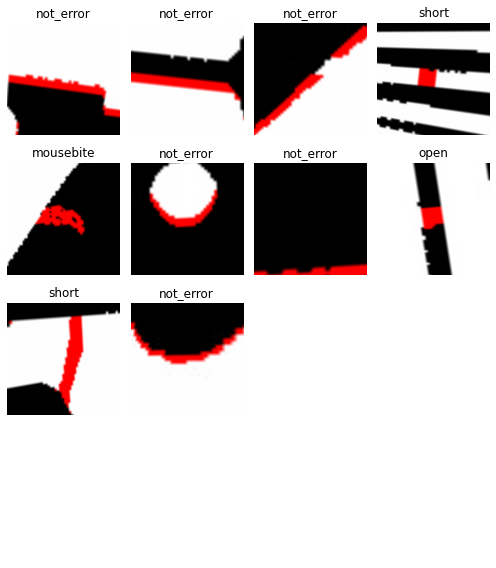

In [ ]:
data.show_batch(rows=4, figsize=(7, 8))

# Training 

In [ ]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=accuracy)  #laoding the resnet34 pretrained weights

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(10) #training for first 10 epochs

epoch,train_loss,valid_loss,accuracy,time
0,1.436245,0.588760,0.776042,00:18
1,1.055682,0.302884,0.885417,00:18
2,0.825050,0.358603,0.885417,00:17
3,0.625106,0.248981,0.921875,00:17
4,0.560044,0.126597,0.963542,00:17
5,0.415863,0.125667,0.968750,00:17
6,0.335059,0.080093,0.973958,00:17
7,0.287937,0.082322,0.979167,00:17
8,0.236808,0.072786,0.984375,00:17
9,0.266451,0.069797,0.979167,00:17


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### unfreezing the layers for better learning and plotting the best learning rate

In [ ]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


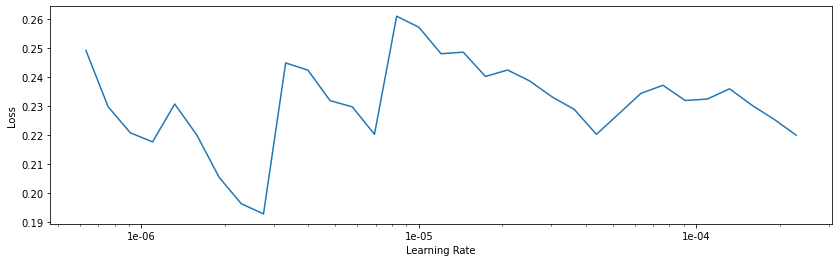

In [ ]:
learn.recorder.plot()

fastai.vision module divides the architecture in 3 groups and trains them with variable learning rates depending on what you input. (Starting layers usually don't require large variations in parameters) <br>

Additionally, if you use 'fit_one_cycle', all the groups will have learning rate annealing with their respective variable learning.

In [ ]:
model_table = learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.279984,0.074735,0.984375,00:18
1,0.247275,0.055091,0.984375,00:18
2,0.209720,0.062083,0.984375,00:18
3,0.224451,0.055271,0.989583,00:18
4,0.256117,0.046544,0.989583,00:18
5,0.191948,0.059892,0.989583,00:18
6,0.201395,0.051984,0.984375,00:18
7,0.178113,0.057369,0.989583,00:18
8,0.187832,0.044334,0.989583,00:18
9,0.241943,0.060233,0.979167,00:18


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


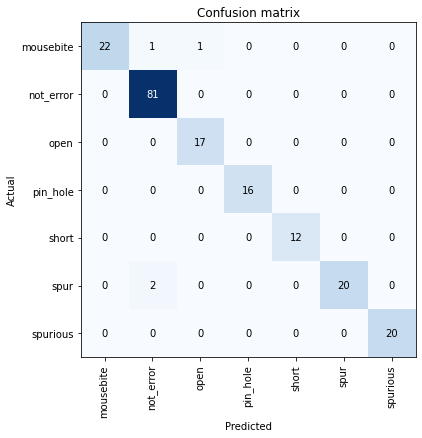

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
#Saving the saved model weights
learn.export('models/resnet34/export.pkl') #saving it as export.pkl as fastai loads that file only 

In [ ]:
learn = load_learner('training_csvs/train/models/resnet34')

In [ ]:
np.random.seed(42)
path = "training_csvs/train/"
test_data = ImageDataBunch.from_folder(path, train='training_csvs/train/', ds_tfms=get_transforms(), size=224, bs=10).normalize(imagenet_stats)

In [ ]:
path = "training_csvs/"
data = ImageDataBunch.from_folder(path, train='train', valid='test', ds_tfms=get_transforms(do_flip=False), size=224, bs=64, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data

ImageDataBunch;

Train: LabelList (1923 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
short,short,short,short,short
Path: training_csvs;

Valid: LabelList (214 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
short,short,short,short,short
Path: training_csvs;

Test: None

In [ ]:
res = learn.validate(data.valid_dl)
res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1.640022, tensor(0.6262)]

In [ ]:
len(res)

2

In [ ]:
learn.data.valid_dl = data_test.valid_dl

In [ ]:
preds, y = learn.get_preds()
acc = accuracy(preds, y)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)
losses,idxs = interp.top_losses()
len(data_test.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Inference (yet to be finalized)

In [ ]:
learn = load_learner('training_csvs/train/models/resnet34')

In [ ]:
#os.mkdir("training_csvs/testing")
#os.mkdir("training_csvs/testing/difference_image")
#os.mkdir("training_csvs/testing/extracted_errors")

In [ ]:
temp_file_path = '6_hold_out/00041000_temp.jpg'
test_file_path = '6_hold_out/00041000_test.jpg'
write_path_b = "training_csvs/testing/difference_image/diff_image_1.png"
write_path_w = "training_csvs/testing/difference_image/diff_image_2.png"
subtract_images(temp_file_path, test_file_path, write_path_b, 1) #black defects
subtract_images(test_file_path, temp_file_path, write_path_w, 2) #white defects

In [ ]:
#os.mkdir("training_csvs/testing/extracted_errors/extracts_1")
#os.mkdir("training_csvs/testing/extracted_errors/extracts_2")
#os.mkdir("training_csvs/testing/all_extracted_errors")

In [ ]:
image_path_b = "training_csvs/testing/difference_image/diff_image_1.png"
image_path_w = "training_csvs/testing/difference_image/diff_image_2.png"
this_write_path_b = "training_csvs/testing/extracted_errors/extracts_1/"
this_write_path_w = "training_csvs/testing/extracted_errors/extracts_2/"
hsv_lower = [0,150,50], #for red colour
hsv_upper = [10,255,255]
extract_contours_from_image(image_path_b, this_write_path_b, hsv_lower, hsv_upper)
extract_contours_from_image(image_path_w, this_write_path_w, hsv_lower, hsv_upper)

In [ ]:
cnt=0
for dirpath, dirs, files in os.walk("training_csvs/testing/extracted_errors"):
  for index, filename in enumerate(files):
    if filename.endswith(".png"):
        cnt += 1
        file_paths = [dirpath + "/" + filename]
        target_directory = "training_csvs/testing/all_extracted_errors/extract_" + str(cnt) + ".png"
        for file in file_paths:
          shutil.move(file, target_directory)

In [ ]:
pred = []
for dirpath, dirs, files in os.walk("training_csvs/testing/all_extracted_errors"):
  for index, filename in enumerate(files):
    if filename.endswith(".png"):
        cnt += 1
        file_paths = [dirpath + "/" + filename]
        print(file_paths[0])
        img = open_image(file_paths[0])
        prediction = learn.predict(img)
        p = learn.data.classes[prediction[1].item()]
        pred.append(p)

training_csvs/testing/all_extracted_errors/extract_1.png
training_csvs/testing/all_extracted_errors/extract_2.png
training_csvs/testing/all_extracted_errors/extract_3.png
training_csvs/testing/all_extracted_errors/extract_4.png
training_csvs/testing/all_extracted_errors/extract_5.png
training_csvs/testing/all_extracted_errors/extract_6.png
training_csvs/testing/all_extracted_errors/extract_7.png
training_csvs/testing/all_extracted_errors/extract_8.png
training_csvs/testing/all_extracted_errors/extract_9.png
training_csvs/testing/all_extracted_errors/extract_10.png


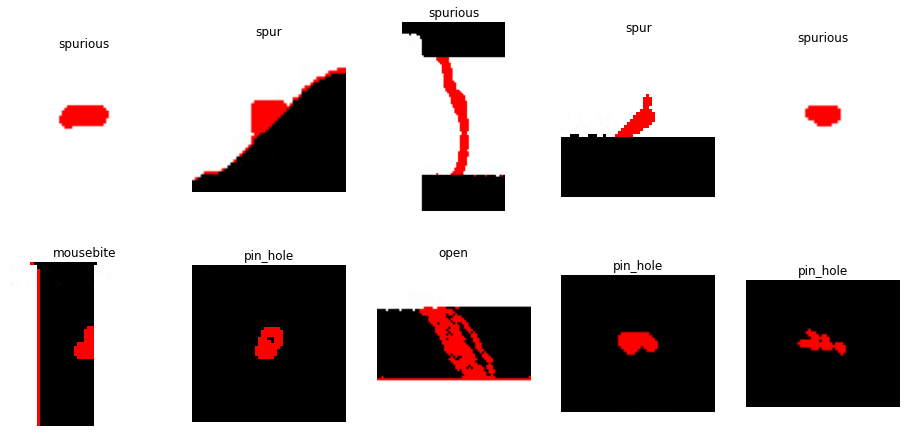

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

train_dir= 'training_csvs/testing/all_extracted_errors'
train = os.listdir(train_dir)
fname1 = [os.path.join(train_dir,fname)
        for fname in train[:]]
ncolu = 4
nrow = 4
fig = plt.gcf()
fig.set_size_inches(ncolu*4,nrow*4)
for i,fname in enumerate(fname1):
    #print (fname)
    sp = plt.subplot(4,5,i+1)
    sp.axis('off')
    sp.title.set_text(pred[i])
    img = mping.imread(fname)
    plt.imshow(img)
plt.show()